## The (1,2,1) Hamiltonian

The electric and magnetic Hamiltonians in the (1,2,1) Hamiltonian are

$$ H_E =  g^2 \left( N_c - \frac{1}{N_c} \right)\left[ \sum_p  P_{1,p} - \frac{1}{2}\sum_p \sum_{\hat{n}} P_{1,p} P_{1,p+\hat{n}} \right] $$

$$ H_B = -\frac{1}{\sqrt{2}g^2} \sum_{p} \left( \prod_{\hat{n}} P_{0,p+\hat{n}} \right) X_p - \frac{1}{2g^2 N_c} \sum_{p} \sum_{\hat{k}} P_{1,p+\hat{k}} \left( \prod_{\hat{n}\neq\hat{k}} P_{0,p+\hat{n}} \right) X_p $$

where $P_0 = |0\rangle\langle 0|$ and $P_1 = |1\rangle\langle 1 |$, where the sum over $\hat{n}$ is a sum over lattice unit vectors.

In this truncation, a pair of neighboring plaquettes can be excited, with the link between the two plaquettes in the 1 representation.

In [1]:
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import eigsh
from scipy.sparse import kron, eye, csr_matrix
import matplotlib.pyplot as plt
from IPython.display import display
from IPython.display import display, Math
from matplotlib.colors import ListedColormap

### Code for defining the Hamiltonian is here:

In [2]:
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
Define functions that implements the operators in the Hamiltonian.
Want to work with sparse matrices.
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

# Create the one-qubit operations
Id =  sparse.csr_matrix(np.array([[1.,0.],[0.,1.]]))
P1 = sparse.csr_matrix(np.array([[0., 0.],[0., 1.]]))
P0 = sparse.csr_matrix(np.array([[1.,0.],[0.,0.]]))
Xop = sparse.csr_matrix(np.array([[0.,1.],[1.,0.]]))


'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
A function that acts with a one-qubit operator on a specified qubit. So, it takes in a 2x2 matrix and spits out a 2^n x 2^n matrix.
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

def one_qubit_gate( 
    M: sparse._csr.csr_matrix, 
    p: int, 
    n: int
    ) -> sparse._csr.csr_matrix:
    if (M.shape != (2,2)):
        print('Warning: Expected M argument to be a 2x2 sparse matrix.')
    if ( p<0 or p>=n ):
        print(f'Warning: Expected p argument to be within the range [0, {n}-1] inclusive.')

    result = eye(1, format='csr') # create a sparse 1x1 matrix to store result
    for i in range(n):
        if (i==p):
            result = kron(result, M, format='csr')
        else:
            result = kron(result, Id, format='csr')  
    return result


'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
    Define a function that returns an n-qubit gate that is in the form of a tensor product of single qubit gates.

    Expects the dictionary op_dict to be of the form { p1: M1, p2: M2, p3: M3 } where the p's are integers specifying
    qubits and the M's are 2x2 matrices in sparse format specifying one-qubit gates.
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

def multi_qubit_gate(
    op_dict: dict, 
    n: int
    ) -> sparse._csr.csr_matrix:
    result = eye(1, format='csr') # Create a 1x1 in sparse format to build our operator
    for i in range(n):
        if i in op_dict:
            result = kron(result, op_dict[i], format='csr')
        else:
            result = kron(result, Id, format='csr')
    return result


'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
Convert between the single-index p which enumerates qubits, and double-index (i,j) which enumerates lattice sites
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

def map_to_circuit( i, j, L, H ):
    if i >= L:
        print(f"[map_to_circuit] i index out of bounds: expected i<{L}, but i={i}")
    if j >= H:
        print(f"[map_to_circuit] j index out of bounds, expected j<{H}, but j={j}")
    
    return j*L + i


def map_to_lattice( p, L, H ):
    if p >= (L*H):
        print(f"[map_to_lattice] p index out of bounds, expected p<{L*H}, but p={p}")

    return p % L, p // L



''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''' 
Create a function that produces the Hamiltonian matrix
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

def make_electric_ham(
    g: float, 
    lat_shape: list, 
    boundary: str = 'periodic', 
    N_colors: int = 3 
) -> sparse._csr.csr_matrix:
    
    # Returns a sparse 2**n x 2**n matrix containing the diagonal part of the Hamiltonian
    L = lat_shape[0]
    H = lat_shape[1]
    n = L*H
    
    H_E = csr_matrix((2**n, 2**n))
    
    for p in range(n):
        H_E += one_qubit_gate(P1, p, n)
        
    if boundary=='periodic':
        for p in range(n):
            i, j = map_to_lattice(p, L, H)
            nr   = map_to_circuit((i + 1) % L, j, L, H)
            nu   = map_to_circuit(i, (j + 1) % H, L, H)
            H_E -= 0.5 * multi_qubit_gate( {p: P1, nr: P1}, n )
            H_E -= 0.5 * multi_qubit_gate( {p: P1, nu: P1}, n )
        
    return (N_colors - 1/N_colors)*g*g * H_E



def make_magnetic_ham(
    g: float, 
    lat_shape: tuple, 
    boundary='periodic',
    N_colors: int = 3
) -> sparse._csr.csr_matrix:
    # Returns a sparse 2**n x 2**n matrix containing the magnetic part of the Hamiltonian
    L = lat_shape[0]
    H = lat_shape[1]
    n = L*H
    mag_prefactor1 = -np.sqrt(2)/(2*g*g)
    mag_prefactor2 = -1/(2*g*g*N_colors)

    H_B1 = csr_matrix((2**n, 2**n))
    H_B2 = csr_matrix((2**n, 2**n))
    
    if (boundary == 'periodic'):
        for p in range(n):
            i, j = map_to_lattice(p, L, H)
            nl   = map_to_circuit((i - 1) % L, j, L, H)
            nd   = map_to_circuit(i, (j - 1) % H, L, H)
            nr   = map_to_circuit((i + 1) % L, j, L, H)
            nu   = map_to_circuit(i, (j + 1) % H, L, H)

            # Apply the X P0 P0 P0 P0 term
            H_B1 += multi_qubit_gate( {p: Xop, nl: P0, nd: P0, nr: P0, nu: P0}, n )

            # Apply the X P0 P0 P0 P1 term
            H_B2 += multi_qubit_gate( {p: Xop, nl: P1, nd: P0, nr: P0, nu: P0}, n )
            H_B2 += multi_qubit_gate( {p: Xop, nl: P0, nd: P1, nr: P0, nu: P0}, n )
            H_B2 += multi_qubit_gate( {p: Xop, nl: P0, nd: P0, nr: P1, nu: P0}, n )
            H_B2 += multi_qubit_gate( {p: Xop, nl: P0, nd: P0, nr: P0, nu: P1}, n )

    H_B = mag_prefactor1 * H_B1  +   mag_prefactor2 * H_B2
    
    return H_B


def make_ham(
    g: float, 
    lat_shape: tuple, 
    boundary: str ='periodic',
    N_colors: int =3
) -> sparse._csr.csr_matrix:
    
    HE = make_electric_ham(g, lat_shape, boundary, N_colors)
    HB = make_magnetic_ham(g, lat_shape, boundary, N_colors)
    return HE + HB


def get_ground_state_energy(g, lat_shape, boundary='periodic', N_colors=3):
    H = make_ham(g, lat_shape, boundary, N_colors)
    evals, evecs = eigsh( H, which='SA', k=1)
    return evals[0]


### Code for drawing states is here:

In [3]:
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
Take in a vector and write it as a sum of kets, with the kets being the computational basis states.
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

def write_state_as_kets( vec, max_num_states=10 ):
    # Get the number of qubits from the length of the vector
    n = int(np.log2(len(vec)))

    # Trim the vector down to its k largest (absolute) values
    vec = keep_k_largest(vec, k=max_num_states)
    
    # Make a list of tuples of the form (coefficient, state) 
    terms = [ (vec[i], format(i, f"0{n}b") ) for i in range(len(vec)) if np.abs(vec[i]) > 0.00000001 ]
    # Sort them in descending order based on their coefficients
    terms = sorted( terms, key=lambda t: abs(t[0]), reverse=True )
    
    # Make this into a list of LaTeX formatted terms
    latex_terms = [ fr'{{{coef:.3f}}}\ket{{{state}}}' for coef, state in terms ]
    expr = " + ".join(latex_terms)
    
    # Write it
    display(Math(expr))
    return

'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
Take in a vector specifying a state, and the lattice shape (L,H), and plot the state.
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

def draw_state( vec, lat_shape, max_num_states=10 ):
    # Convert the lattice shape to an array shape
    arr_shape = (lat_shape[1], lat_shape[0])
    
    # Get the number of qubits from the lattice shape, and make sure the vector and lattice shapes are compatible
    L, H = lat_shape[0], lat_shape[1]
    n = L*H
    if n != int(np.log2(len(vec))):
        print(f"[draw_state]: The number of qubits in vec ({int(np.log2(len(vec)))}) and the lattice shape ({lat_shape}) are not compatible")

    # Trim the vector down to its k largest (absolute) values
    vec = keep_k_largest(vec, k=max_num_states)

    # Make a list of tuples of the form (coefficient, binary_string), sorted by size of coefficient
    terms = [ (vec[i], format(i, f"0{n}b") ) for i in range(len(vec)) if np.abs(vec[i]) > 0.0000001 ]
    terms = sorted( terms, key=lambda t: abs(t[0]), reverse=True )

    
    # Create side-by-side plots
    fig, axs = plt.subplots(1, len(terms), figsize=(len(terms)*1.5, 1.5))

    # Handle edge case
    if len(terms) == 1:
        axs = [axs]

    for ax, term in zip(axs, terms):
        create_binary_plot_on_ax(ax, term[1], arr_shape)

    plt.tight_layout()
    plt.show()
    return



'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
# Create a function that takes in a binary string and a lattice shape, and plots the corresponding state
# The binary string should be of length L*H, where L and H are the dimensions of the lattice.
# The function should create a 2D plot of the binary string, with 0s and 1s represented by different colors.
# The function should also allow for optional gridlines to be drawn, to indicate the borders of the lattice.
# The function should draw the state using a different color if the state is not physical.
# For an unphysical state, the cluster containing a cycle is drawn in red.
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

def create_binary_plot(binary_str, lat_shape, borders=True):
    # Start by converting the binary string into a binary array
    binary_array = binary_array_from_list( binary_str, lat_shape )
    vmax = 1 # Default max value for the colormap
    
    # Create custom colormap
    cmap = ListedColormap(["#003366", "#FFD700"])

    # Check if the state is physical
    is_physical, cluster = is_physical_state(binary_str, lat_shape)

    # If the state is not physical, color the cluster containing a cycle in red
    if not is_physical:
        # Create a copy of the binary array to modify
        binary_array = np.copy(binary_array)
        # Set the cluster containing a cycle to red
        for x, y in cluster:
            binary_array[x, y] = 2
        cmap = ListedColormap(["#003366", "#FFD700", "#FF0000"])
        vmax = 2 # Set max value for the colormap to include the red color


    # Create the plot
    fig, ax = plt.subplots(figsize=(lat_shape[0], lat_shape[1]))
    im = ax.imshow(binary_array, cmap=cmap, interpolation="none", vmin=0, vmax=vmax)

    # Style the plot
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)

    # Optional: add gridlines if you want to see borders
    if borders==True:
        plt.grid(color='white', linewidth=1)
        plt.gca().set_xticks(np.arange(-.5, lat_shape[0], 1), minor=True)
        plt.gca().set_yticks(np.arange(-.5, lat_shape[1], 1), minor=True)
        plt.gca().grid(which="minor", color="white", linewidth=2)
        plt.gca().tick_params(which="minor", bottom=False, left=False)

    plt.close(fig)  # prevent automatic display

    # Return the figure and axis for later use
    return fig, ax


'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
Take in a binary string representing a computational basis state and determine if the state is physical or not.
In the (1,2,1) Hamiltonian, you can check if a computational basis state is physical in the following way:
1. Create a set of disjointed graphs by connecting all neighboring 1's to each other.
2. Check if any of the graphs have any cycles.
3. If any of the graphs have cycles, the state is not physical. Otherwise, it is physical.
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''

def is_physical_state( binary_str, lat_shape ):
    # Convert the binary string into a binary array
    binary_array = binary_array_from_list( binary_str, lat_shape )

    arr_shape = (lat_shape[1], lat_shape[0])

    # Loop through the binary array and find all the clusters of 1's
    clusters = []
    visited = np.zeros_like(binary_array, dtype=bool)
    for i in range(arr_shape[0]):
        for j in range(arr_shape[1]):
            if binary_array[i, j] == 1 and not visited[i, j]:
                # Start a new cluster
                cluster = []
                stack = [(i, j)]
                while stack:
                    x, y = stack.pop()
                    if visited[x, y]:
                        continue
                    visited[x, y] = True
                    cluster.append((x, y))
                    # Check neighbors
                    for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                        nx, ny = (x + dx) % arr_shape[0], (y + dy) % arr_shape[1]
                        if binary_array[nx, ny] == 1 and not visited[nx, ny]:
                            stack.append((nx, ny))
                clusters.append(cluster)

    # Check if any of the clusters have cycles
    for cluster in clusters:
        # Create a set to keep track of visited nodes
        visited = set()
        stack = [cluster[0]]
        while stack:
            node = stack.pop()
            if node in visited:
                # Print the cycle for debugging
                # print("Cycle detected in cluster:", cluster)
                # Cycle detected
                return False, cluster
            # Mark the node as visited 
            visited.add(node)
            # Check neighbors
            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                nx, ny = (node[0] + dx) % arr_shape[0], (node[1] + dy) % arr_shape[1]
                if (nx, ny) in cluster and (nx, ny) not in visited:
                    stack.append((nx, ny))
    # If no cycles were found, the state is physical
    return True, []



'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
Helper functions below
'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''


# Helper function, to turn a binary string into an array with the shape of the lattice
def binary_array_from_list( binary_str: str, lat_shape: tuple):
    arr_shape = (lat_shape[1], lat_shape[0])

    # Check if the length of the binary string matches the expected size
    if len(binary_str) != arr_shape[0] * arr_shape[1]:
        raise ValueError(f"Binary string length {len(binary_str)} does not match expected size {arr_shape[0] * arr_shape[1]}")
    # Check if the binary string contains only 0s and 1s
    if not all(bit in '01' for bit in binary_str):
        raise ValueError("Binary string must contain only 0s and 1s")
    # Convert the string into a list of integers (0s and 1s)
    binary_list = [int(bit) for bit in binary_str]

    # Convert the list into a NumPy array with the desired shape
    binary_array = np.array(binary_list).reshape(arr_shape)

    return binary_array


# The create_binary_plot function, now slightly tweaked to draw on an Axes object
# Helper function for draw_state()
# Like the create_binary_plot function, it will check if the state is physical or not, and color the cluster containing a cycle in red.
def create_binary_plot_on_ax(ax, binary_str, shape):
    binary_array = np.array([int(b) for b in binary_str]).reshape(shape)
    cmap = ListedColormap(["#003366", "#FFD700"])
    vmax = 1 # Default max value for the colormap
    # Check if the state is physical
    is_physical, cluster = is_physical_state(binary_str, shape)
    # If the state is not physical, color the cluster containing a cycle in red
    if not is_physical:
        # Set the cluster containing a cycle to red
        for x, y in cluster:
            binary_array[x, y] = 2
        cmap = ListedColormap(["#003366", "#FFD700", "#FF0000"])
        vmax = 2 # Set max value for the colormap to include the red color

    ax.imshow(binary_array, cmap=cmap, interpolation="none", vmin=0, vmax=vmax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)

    
# Helper function, trip an array to only its k largest values
def keep_k_largest(arr, k):
    # Make a copy so we don't modify the original
    result = np.zeros_like(arr)
    
    # Get indices of the k largest absolute values
    if k > 0:
        idx = np.argpartition(np.abs(arr), -k)[-k:]
        result[idx] = arr[idx]
    
    return result




#'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
#Old code below
#'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''


# '''
# Takes in a string like "0001001000" specifying a computational basis state |0001001000>, and spits out the corresponding
# vector of length 2^n. This vector will be a "one shot" vector, with only a single nonzero entry (which will
# be equal to 1).

# Also write an inverse function, mapping oneshot vectors to basis state strings.
# '''

#def show_ket(bitstring):
#    from IPython.display import display, Math
#    display(Math(fr'\ket{{{bitstring}}}'))

    

# def list_to_oneshot_vector(config: str):
#     n = len(config)
#     vec = np.zeros(2**n)
#     vec[int(config, 2)] = 1
#     return vec


# def oneshot_vector_to_list(vec: np.ndarray) -> str:
#     index = np.argmax(vec)  # gets the index where the 1 is
#     n = int(np.log2(len(vec)))  # number of bits in the original string
#     binary_str = format(index, f"0{n}b")  # convert to binary and pad with zeros
#     return binary_str


### Unphysically degenerate electric vacuum

The new electric Hamiltonian nominally has a degenerate ground state, as can be seen by diagonalizing it and printing the two lowest energies:

In [4]:
g = 1.
lat_shape = (3,3)

H = make_electric_ham(g, lat_shape)
evals, evecs = eigsh(H, k=10, which='SA')

print(f"The two lowest energies are {evals[0]:.{4}f} and {evals[1]:.{4}f}.")

The two lowest energies are -0.0000 and 0.0000.


One of these states is the physical electric vacuum $|00...0\rangle$. The other one is the state $|11...1\rangle$, which at first glance appears to be a maximally excited state. However, it has no meaning within this truncation scheme, because it allows more than two nieghboring plaquettes to be excited (in this case, all of them). The interaction term $\sim P_1 P_1$ in the electric Hamiltonian is attractive, and with just the right prefactor to cause the electric energy of the $|11...1\rangle$ state to vanish. However, the dyanmics does not couple to this state, and with proper error mitigation this unphysical state should not show up at all in practice.

In [5]:
# See the two ground state eigenvectors explicitly:
g = 1.
lat_shape = (3,3)

H = make_electric_ham(g, lat_shape)
evals, evecs = eigsh(H, k=2, which='SA')

print("The first (degenerate) electric vacuum is:")
write_state_as_kets(evecs[:,0] )
print("The second (degenerate) electric vacuum is:")
write_state_as_kets(evecs[:,1])

The first (degenerate) electric vacuum is:


<IPython.core.display.Math object>

The second (degenerate) electric vacuum is:


<IPython.core.display.Math object>



### Magnetic hamiltonian spectrum as a function of coupling

In [6]:
lat_shape = (4,4)
gvals = np.array([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2])

num_evals = 20

energies = []

for i in range(len(gvals)):
    g = gvals[i]
    h = make_magnetic_ham(g, lat_shape)
    evals, evecs = eigsh( h, which='SA', k=num_evals )
    energies.append(evals)
    print(f"Diagonzalization up to g={g} complete.", end='\r')

#Make plots
fig, ax = plt.subplots()

plt.title(f"{num_evals} lowest lying energies of magnetic hamiltonian L={lat_shape[0]}") 
plt.xlabel("g") 
plt.ylabel("Spectrum")

offset=0.05

for k in range(num_evals):
    ax.plot( gvals, [i[k]-i[0]+k*offset for i in energies] ,'-')

plt.show()

KeyboardInterrupt: 

## Spectrum as a function of coupling

In [ ]:
lat_shape = (3,3)
gvals = np.linspace(0.65, 1.05, 20)
boundary = "periodic"

num_evals = 100

energies = []

for i in range(len(gvals)):
    g = gvals[i]
    h = make_ham(g, lat_shape, boundary)
    evals, evecs = eigsh( h, which='SA', k=num_evals )
    energies.append(evals)
    # show progress
    print(f"Diagonzalization up to g={g:.2f} complete.", end='\r')

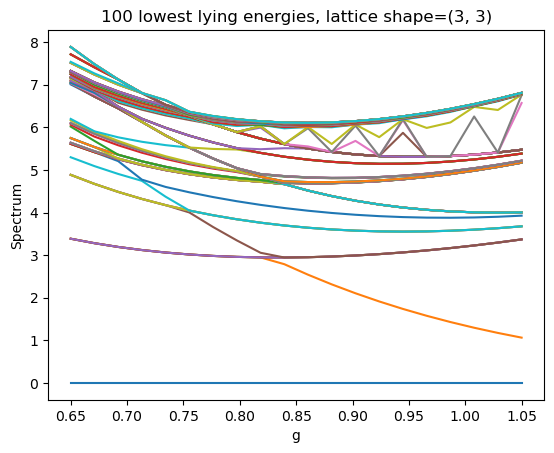

In [ ]:
#Make plots
fig, ax = plt.subplots()

plt.title(f"{num_evals} lowest lying energies, lattice shape={lat_shape[0], lat_shape[1]}") 
plt.xlabel("g") 
plt.ylabel("Spectrum")

offset=0.0

for k in range(num_evals):
    ax.plot( gvals, [i[k]-i[0]+k*offset for i in energies] ,'-')

plt.show()

## View the basis states that contribute to the first few energy eigenstates

The ```draw_state( vec, lat_shape )``` function lets you visualize the basis states that make up a state ```vec```, ordered from largest overlap to smallest overlap.

The states making up the ground state are:


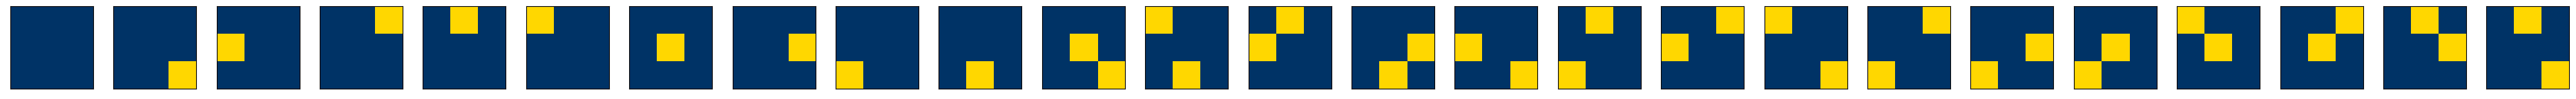

The states making up the unphysical first excited state are:


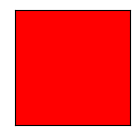

In [ ]:
# Pick some parameters
g = 1.
lat_shape = (3,3)

# Diagonalize the Hamiltonian
H = make_ham(g, lat_shape)
evals, evecs = eigsh(H, k=10, which='SA')

ground_state = evecs[:,0]
false_ground_state = evecs[:,1]

print("The states making up the ground state are:")
draw_state( ground_state , (3,3), 25 )
print("The states making up the unphysical first excited state are:")
draw_state( false_ground_state , (3,3), 28 )

You can also use the function ```write_state_as_kets( vec, max_num_states )``` to write out a state ```vec``` as a linear combination of basis states, ordered from largest to smallest overlap.

In [ ]:
# We can also write the ground state as a sum of kets to see the coefficients
write_state_as_kets( ground_state, max_num_states=28 )

write_state_as_kets( false_ground_state, max_num_states=28 )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Flag unphysical basis states

Use the function ```is_physical_state( binary_str, lat_shape )``` to determine if a given state $| "01001... 1" \rangle$ is physical or not. The function returns a tuple ```(is_physical, cluster)``` containing a bool ```is_physical``` that is ```True``` if the state is physical and ```False``` if it is unphysical. The ```cluster``` is a list of array indicies indicating the cluster of 1's that causes the state to be unphysical. This is useful for plotting the state, if you want to color-code the unphysical states. 

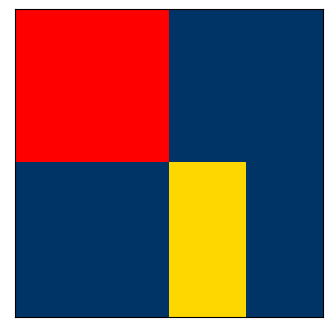

The state 1100110000100010 is unphysical.


[(0, 0), (0, 1), (1, 1), (1, 0)]

In [ ]:
# Create an unphysical state
binary_string = "1100110000100010"
lat_shape = (4, 4)

# Plot the unphysical state
fig, ax = create_binary_plot(binary_string, lat_shape, borders=False)
display(fig)

# View the output of the is_physical_state function
is_physical, cluster = is_physical_state(binary_string, lat_shape)
print(f"The state {binary_string} is {'physical' if is_physical else 'unphysical'}.")
cluster

# What fraction of the computational basis states are unphysical?

In [ ]:
unphysical_fraction = []

for L in range(2, 5):
    for H in range(L, 6):
        lat_shape = (L, H)
        n = L*H  # number of bits in the original string

        physical_list = []

        for i in range(2**n):
            binary_str = format(i, f"0{n}b")  # convert to binary and pad with zeros
            is_physical, cluster = is_physical_state(binary_str, lat_shape)
            if is_physical:
                physical_list.append( binary_str )
        unphysical_fraction.append((lat_shape,1 - len(physical_list) / 2**n))
        # make the print statement write over iteself each time
        print(f"L={L}, H={H}, fraction of unphysical states = {1 - len(physical_list) / 2**n:.4f}", end='\r')
        
# plot the unphysical fraction as a bar plot, with the x-axis being the lattice shape.
# The bars should be ordered from smallest to largest fraction of unphysical states.
unphysical_fraction = sorted(unphysical_fraction, key=lambda x: x[1])
# Create a bar plot
fig, ax = plt.subplots()
x = np.arange(len(unphysical_fraction))
width = 0.35
ax.bar(x, [i[1] for i in unphysical_fraction], width, label='Unphysical fraction')
ax.set_ylim(0, 1)
ax.set_ylabel('Fraction of unphysical states')
ax.set_title('Fraction of unphysical states for different lattice shapes')
ax.set_xticks(x)
ax.set_xticklabels([f"{i[0][0]}x{i[0][1]}" for i in unphysical_fraction])
ax.legend()
plt.show()

L=2, H=2, fraction of unphysical states = 0.5625
L=2, H=3, fraction of unphysical states = 0.6094
L=2, H=4, fraction of unphysical states = 0.6914
L=2, H=5, fraction of unphysical states = 0.7646
L=3, H=3, fraction of unphysical states = 0.5293
L=3, H=4, fraction of unphysical states = 0.5779
L=3, H=5, fraction of unphysical states = 0.6338
L=4, H=4, fraction of unphysical states = 0.6183
L=4, H=5, fraction of unphysical states = 0.6706


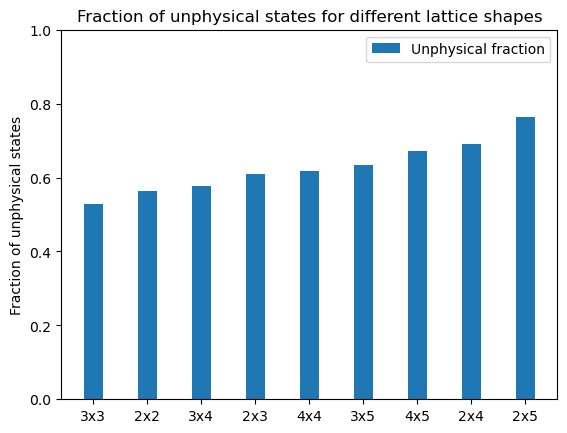

# Precompute a dictionary of all physical and unphysical states

The code-snippet below will load the file (by default named ```is_physical_dict.pkl```) into the variable ```is_physical_dict```, or, if the file does not yet exist, it creates the file and populates it with data.

In [1]:
# The entries in the dictionary are of the form { (binary_string, lat_shape): is_physical }
# The loop has a progress bar, and the dictionary is saved to a file 'is_physical_dict.pkl'.
from tqdm import tqdm
import pickle
import os

def save_is_physical_dict(filename, is_physical_dict):
    with open(filename, 'wb') as f:
        pickle.dump(is_physical_dict, f)
    print(f"Dictionary saved to {filename}")

def load_is_physical_dict(filename):
    if os.path.exists(filename):
        with open(filename, 'rb') as f:
            is_physical_dict = pickle.load(f)
        print(f"Dictionary loaded from {filename}")
        return is_physical_dict
    else:
        print(f"File {filename} does not exist.")
        return None

# Load the dictionary if it exists, otherwise create it
filename = "is_physical_dict.pkl"
is_physical_dict = load_is_physical_dict(filename)
# If the dictionary is None, create it
if is_physical_dict is None:
    is_physical_dict = {}
    # Loop through all possible lattice shapes of interest
    for L in tqdm(range(2, 5)):
        for H in range(L, 6):
            lat_shape = (L, H)
            n = L*H  # number of bits in the original string

            # Loop through all possible binary strings
            for i in range(2**n):
                binary_str = format(i, f"0{n}b")  # convert to binary and pad with zeros
                is_physical, cluster = is_physical_state(binary_str, lat_shape)
                is_physical_dict[(binary_str, lat_shape)] = is_physical
    # Save the dictionary to a file
    save_is_physical_dict(filename, is_physical_dict)





# Create a function that takes in a state vector and a lattice shape, and returns whether the state is physical or not
def is_physical_state_from_vector(state_vector, lat_shape):
    n = int(np.log2(len(state_vector)))
    if n != lat_shape[0] * lat_shape[1]:
        raise ValueError(f"State vector length {len(state_vector)} does not match expected size {lat_shape[0] * lat_shape[1]}")
    
    # Check if the dictionary is loaded
    if is_physical_dict is None:
        raise ValueError("is_physical_dict is not loaded. Please load it first.")

    # For each nonzero entry in the state vector, check if the corresponding binary string is in the dictionary
    for i in range(len(state_vector)):
        if np.abs(state_vector[i]) >= 0.000001:
            binary_str = format(i, f"0{n}b")  # convert to binary and pad with zeros
            if (binary_str, lat_shape) in is_physical_dict:
                if is_physical_dict[(binary_str, lat_shape)]:
                    continue
                else:
                    return False
            else:
                raise ValueError(f"Binary string {binary_str} not found in the dictionary for lattice shape {lat_shape}")
    return True

Dictionary loaded from is_physical_dict.pkl


## Check whether a state is physical or not

A state ```vec``` is physical if it has no overlap with the unphysical basis states. The function ```is_physical_state_from_vector(state_vector, lat_shape)``` determines whether the state has such an overlap, within numerical precision 10e-7.

In [2]:
# Example usage of the is_physical_state_from_vector function

g = 1.
lat_shape = (3,3)
H = make_ham(g, lat_shape)
evals, evecs = eigsh(H, k=2, which='SA')
print( is_physical_state_from_vector(evecs[:,0], lat_shape) )
print( is_physical_state_from_vector(evecs[:,1], lat_shape) )


NameError: name 'make_ham' is not defined

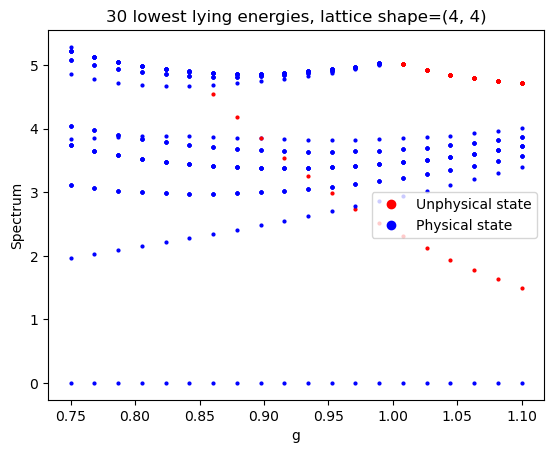

In [ ]:
# Plot the low lying spectrum of the Hamiltonian as a function of g, with the unphysical states highlighted
def plot_spectrum_with_unphysical_states(gvals, lat_shape, num_evals=10):

    offset=0.00

    energies = []
    # Create a list to store which states are unphysical
    unphysical_states = []

    for i in range(len(gvals)):
        g = gvals[i]
        h = make_ham(g, lat_shape, boundary)
        evals, evecs = eigsh( h, which='SA', k=num_evals )
        energies.append(evals)
        # Check if the state is physical and store the result in the list  
        for j in range(num_evals):
            is_physical = is_physical_state_from_vector(evecs[:,j], lat_shape)
            unphysical_states.append((g, j, is_physical))

        # show progress
        print(f"Diagonzalization up to g={g:.2f} complete.", end='\r')
        

    #Make plots
    fig, ax = plt.subplots()

    plt.title(f"{num_evals} lowest lying energies, lattice shape={lat_shape[0], lat_shape[1]}") 
    plt.xlabel("g") 
    plt.ylabel("Spectrum")

    offset=0.0

    # Plot the energies, highlighting the unphysical states by checking the unphysical_states list to see if the state is unphysical
    for k in range(num_evals):
        for i in range(len(gvals)):
            g = gvals[i]
            if unphysical_states[num_evals*i + k][2] == False:
                ax.plot( g, energies[i][k]-energies[i][0]+k*offset, 'ro', markersize=2)
            else:
                ax.plot( g, energies[i][k]-energies[i][0]+k*offset, 'bo', markersize=2)
    # Create a legend
    ax.plot([], [], 'ro', label='Unphysical state')
    ax.plot([], [], 'bo', label='Physical state')
    ax.legend(loc='best')
    plt.show()


# Example usage
gvals = np.linspace(0.75, 1.1, 20)
lat_shape = (4, 4)
plot_spectrum_with_unphysical_states(gvals, lat_shape, num_evals=30)



In [ ]:
g = 1.1
lat_shape = (4, 4)

h = make_ham(g, lat_shape)
evals, evecs = eigsh( h, which='SA', k=30 )

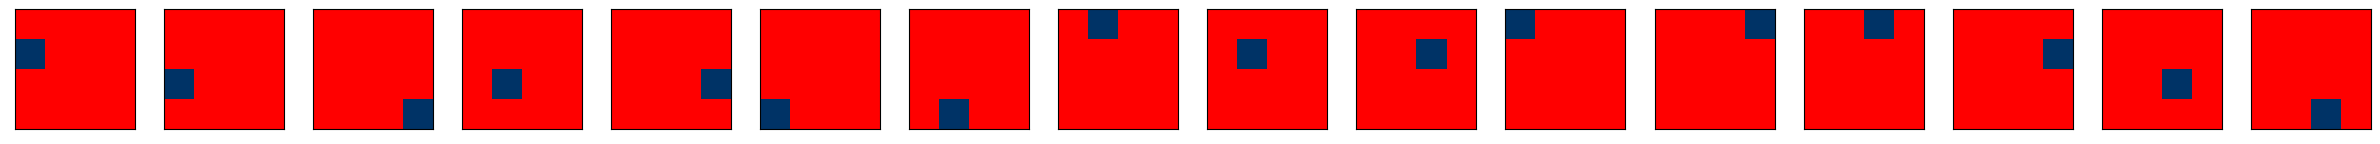

In [ ]:
draw_state( evecs[:,18], lat_shape, max_num_states=20 )

In [ ]:
H = make_ham(1., (3,3))

evals, evecs = sparse.linalg.eigsh(H, which="SA", k = 5)

In [ ]:
get_ground_state_energy(1., (3,3), boundary="periodic", N_colors=3)

-1.3440614971746758

In [ ]:
evals

array([-1.34406150e+00,  7.65563933e-16,  1.85869397e+00,  1.85869397e+00,
        1.85869397e+00])

In [ ]:
H.shape

(512, 512)

In [ ]:
H_elec = make_electric_ham(1., (3,3), boundary="periodic", N_colors=3)

evals, evecs = sparse.linalg.eigsh(H_elec, which="SA", k=20)